In [0]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
from shutil import copyfile
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

import cv2
import time
import multiprocessing

import tensorflow as tf
import tensorflow.keras
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import numpy.random as rng

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4706115119017737630, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4411526468806978023
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12473501766217052636
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17038270959921213366
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"]

In [0]:
tf.test.is_gpu_available()

True

### Please give below paths as per the paths in your system

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#!ls /content/drive/My\ Drive/

In [0]:
#base_folder = "/content/drive/My Drive/colab_apps/SpeakerRecognition/TIMIT/"
#data_folder = base_folder + "/data"
#train_audio_folder = base_folder + "/Audio/TRAIN/"
#test_audio_folder = base_folder + "/Audio/TEST/"
#save_path = '/content/drive/My Drive/colab_apps/SpeakerRecognition/data/'
#output_folder = base_folder + "/npydata/"
#model_path = '/content/drive/My Drive/colab_apps/SpeakerRecognition/Weights/'

In [0]:
base_folder = "/home/ubuntu/notebooks/SpeakerRecognition/"
#data_folder = base_folder + "/data"
save_path =  base_folder + 'data/'
#train_audio_folder = base_folder + "/Audio/TRAIN/"
#test_audio_folder = base_folder + "/Audio/TEST/"
#output_folder = base_folder + "/npydata/"
model_path = '/home/ubuntu/notebooks/SpeakerRecognition/Weights/'

In [0]:
#def initialize_weights(shape, name=None):
def initialize_weights(shape, dtype=None):
    
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
def initialize_bias(shape, dtype=None):
    
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [0]:
def get_base_conv_encoder(input_shape):
     # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                   #kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
                   kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), kernel_regularizer=l2(2e-4)))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3,3), activation='relu',
                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
  #  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
  #                   bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
  #  model.add(MaxPooling2D(pool_size=(2, 2)))
  #  model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
  #                   bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(516, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),bias_initializer=initialize_bias))
    return model
    

In [0]:
####loss functions
from tensorflow.keras import backend as K

def cosine_similarity(vectors):
    #tf.print("COS:")
    x, y = vectors
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    #tf.print("COS:", -K.mean(x * y, axis=-1, keepdims=True))
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)



In [0]:
def build_final_model(input_shape,  distance_metric='uniform_euclidean'):
    
    assert distance_metric in ('uniform_euclidean', 
                                'weighted_l1',
                                'cosine_distance')
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = get_base_conv_encoder(input_shape)
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    
    if distance_metric == 'weighted_l1':
        print("using Weighted_l1")
        

        L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
      
    if distance_metric == 'uniform_euclidean':
        print("inside euclidian")
        
        L1_layer = Lambda(lambda tensors:K.sqrt(K.sum(K.square(K.abs(tensors[0] - tensors[1])),axis=-1, keepdims=True)))
        
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

   
    if distance_metric == 'cosine_distance':
        print("using cosine similarity")
        
        L1_layer = Lambda(cosine_similarity, output_shape=cos_dist_output_shape)
        
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    # return the model
    return siamese_net  

In [0]:


loss_function = 'uniform_euclidean'
model = build_final_model((188, 40, 1), loss_function)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
inside euclidian
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 188, 40, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 188, 40, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 516)          23852804    input_1[0][0]                    
                                                                 input_2[0][

In [0]:
with tf.device('/device:XLA_GPU:0'):
    optimizer = Adam(lr = 0.00006)
    model.compile(loss="binary_crossentropy",metrics=['accuracy'], optimizer=optimizer)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Loading the train tensors

In [0]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
#print("Training Person IDs: \n")
#print(list(train_classes.keys()))

# Load validation Tensors

In [0]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xtest, test_classes) = pickle.load(f)
#print("Validation alphabets:", end="\n\n")
#print(list(test_classes.keys()))

In [0]:
print(Xtest.shape)

(168, 10, 188, 40)


In [0]:
def generate_rnd_pairs(numofcategories=2, s = 'train'):
    
    if s == 'train':
            X = Xtrain
            #print("\ntrain\n")
            #categories = train_classes
    else:
            X = Xtest
            #print("\ntest\n")
            #categories = test_classes
    n_classes, n_samples, w, h = X.shape
    categories = rng.choice(n_classes,size=(numofcategories,),replace=False)
    #print(categories)
    batchsize = numofcategories * numofcategories * X.shape[1] * X.shape[1]
    #print("batchsize:", batchsize)
    pairs=[np.zeros((batchsize , w, h,1)) for i in range(2)]
    #pairs=[np.zeros((w, h,1)) for i in range(2)]
    #print(pairs.shape)
    targets=np.zeros((batchsize,))
    outercounter = X.shape[0]
    innercounter = X.shape[0]
    
    sample = 0
    for i in range(numofcategories):
        category_1 = categories[i]
        #print("outer:", i)
        for idx1 in range(X.shape[1]):
            for j in range(numofcategories):
                category_2 = categories[j]
                #print(sample)
                #print(category_1,category_2, idx1)
                for idx2 in range(X.shape[1]):
                    pairs[0][sample,:,:,:] = X[category_1, idx1].reshape(w, h, 1)
                    pairs[1][sample,:,:,:] = X[category_2, idx2].reshape(w, h,1)
                    if category_1 == category_2:
                        #print("loading from same category")
                        targets[sample] = 1
                        #print("Sample same", sample)
                    sample = sample + 1
                    
                    
    return pairs, targets

In [0]:
def generate_rnd_samples(numofcategories=1, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = generate_rnd_pairs(numofcategories,s)
        yield (pairs, targets)

In [0]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path + '/seg_' + loss_function +
            '_weights.best.hdf5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

In [0]:
# Hyper parameters
#evaluate_every = 200 # interval for evaluating on one-shot tasks
evaluate_every = 1
batch_size = 3
epochs = 20
stepsforepoch = 32
#n_iter = 20000 # No. of training iterations
n_iter = 20 # No. of training iterations
N_way = 20 # how many persons for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [0]:
#model_path = '/home/ubuntu/notebooks/sdaai-pdc2-students/iti110/SpeakerRecognition/Weights/'
print (tf.test.gpu_device_name())

/device:GPU:0


In [0]:
print("Starting training process!")
print("-------------------------------------")
#t_start = time.ti
#me()#
history_list = []
for i in range(n_iter):
    #(inputs,targets) = get_batch(batch_size)
    print("Iteration # : " , i)
    #loss = model.train_on_batch(inputs, targets)
    
    history = model.fit_generator(generate_rnd_samples(batch_size), 
                                  steps_per_epoch=stepsforepoch, 
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=callbacks_list, 
                                  validation_data=generate_rnd_samples(2,'val'),
                                  validation_steps=10, 
                                  validation_freq=1)

    #fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
    #print("history:" ,history.history)
    history_list.append(history)
    
'''
for i in  range(len(history_list)):
     history = history_list[i]
     display_training_loss_and_accuracy(i, history)
'''
    #if i % evaluate_every == 0:

        #print("\n ------------- \n")
        #print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        #print("Train Loss: {0}".format(history.history["loss"])) 
       # val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        #model.save_weights(os.path.join(model_path, 'model.a.{epoch:04d}-acc-{acc:4.2f}-val_acc-{val_acc:4.2f}-loss-{val_loss:4.2f}.h5'))
       # if val_acc >= best:
       #     print("Current best: {0}, previous best: {1}".format(val_acc, best))
       #     best = val_acc

Starting training process!
-------------------------------------
Iteration # :  0
Epoch 1/20
32/32 [==============================] - 32s 991ms/step - loss: 0.4105 - acc: 0.7782 - val_loss: 0.5061 - val_acc: 0.6820
Epoch 2/20
32/32 [==============================] - 32s 995ms/step - loss: 0.3983 - acc: 0.7905 - val_loss: 0.5166 - val_acc: 0.7280
Epoch 3/20
32/32 [==============================] - 32s 997ms/step - loss: 0.4014 - acc: 0.7817 - val_loss: 0.5475 - val_acc: 0.6850
Epoch 4/20
32/32 [==============================] - 32s 1s/step - loss: 0.3790 - acc: 0.8089 - val_loss: 0.4994 - val_acc: 0.7240
Epoch 5/20
32/32 [==============================] - 32s 993ms/step - loss: 0.3916 - acc: 0.7999 - val_loss: 0.4573 - val_acc: 0.7795
Epoch 6/20
32/32 [==============================] - 32s 995ms/step - loss: 0.4095 - acc: 0.7901 - val_loss: 0.4358 - val_acc: 0.7570
Epoch 7/20
32/32 [==============================] - 32s 1s/step - loss: 0.4029 - acc: 0.7925 - val_loss: 0.5140 - val_acc: 

'\nfor i in  range(len(history_list)):\n     history = history_list[i]\n     display_training_loss_and_accuracy(i, history)\n'

In [0]:
def display_training_loss_and_accuracy(iteration, history):
    
    title1 = 'model accuracy for iteration :' + str(iteration)
    title2 = 'model loss for iteration :' + str(iteration)
    plt.figure(figsize=(20,4))
    epoch_count = range(1, len(history.history['acc']) + 1)
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count,history.history['acc'])
    plt.plot(epoch_count,history.history['val_acc'])
    plt.title(title1)
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count,history.history['loss'])
    plt.plot(epoch_count,history.history['val_loss'])
    plt.title(title2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

{'val_loss': [0.5061389714479446, 0.516611111164093, 0.5474621951580048, 0.49938438832759857, 0.4572730153799057, 0.4357523381710052, 0.5139975816011428, 0.490400156378746, 0.4299125880002975, 0.4599657654762268, 0.5460497111082077, 0.5001811385154724, 0.6066689193248749, 0.5181461900472641, 0.517328855395317, 0.5143391013145446, 0.5721422016620636, 0.5580076724290848, 0.5222394734621048, 0.5401221752166748], 'acc': [0.7781945, 0.79048616, 0.78173614, 0.8088889, 0.7999306, 0.79006946, 0.7925, 0.78875, 0.78770834, 0.8017361, 0.77631944, 0.8142361, 0.8022917, 0.80635417, 0.7957639, 0.79520833, 0.815625, 0.79395837, 0.7982639, 0.81187505], 'val_acc': [0.68200004, 0.72800004, 0.68500006, 0.72400004, 0.7795, 0.757, 0.70100003, 0.67700005, 0.772, 0.749, 0.69000006, 0.70900005, 0.64100003, 0.6945, 0.707, 0.7045, 0.669, 0.652, 0.688, 0.7135], 'loss': [0.4104927210137248, 0.3982985820621252, 0.401397155597806, 0.37904067151248455, 0.39157415833324194, 0.4094610661268234, 0.4029385931789875, 0.3

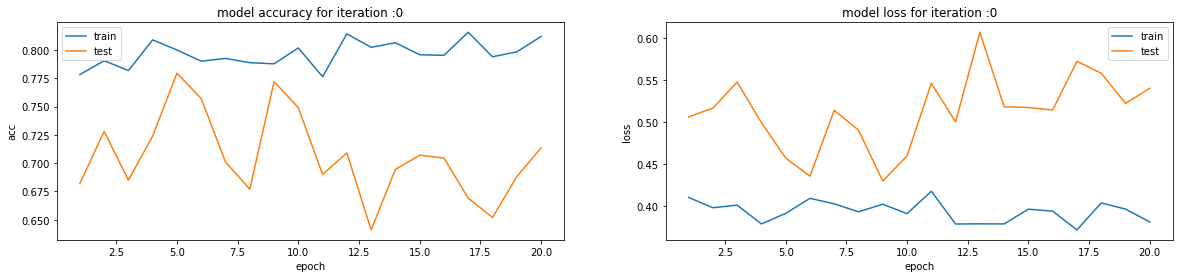

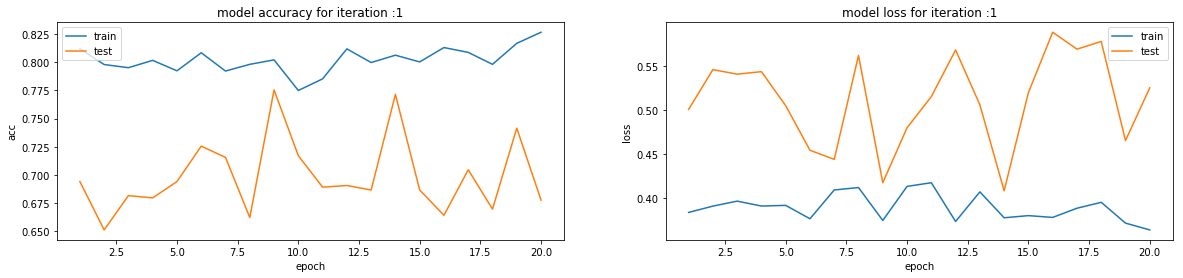

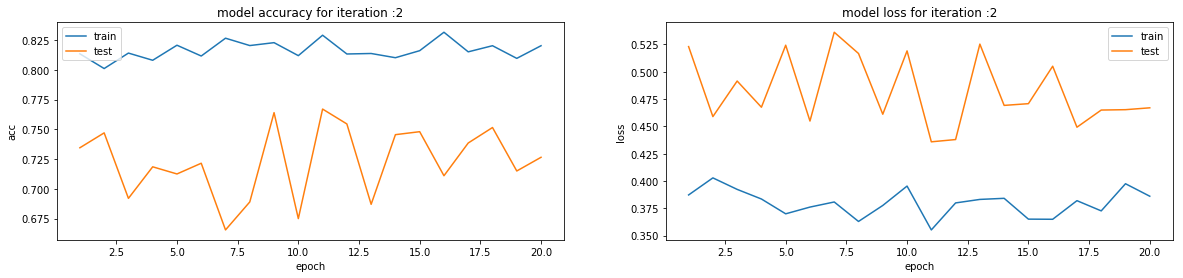

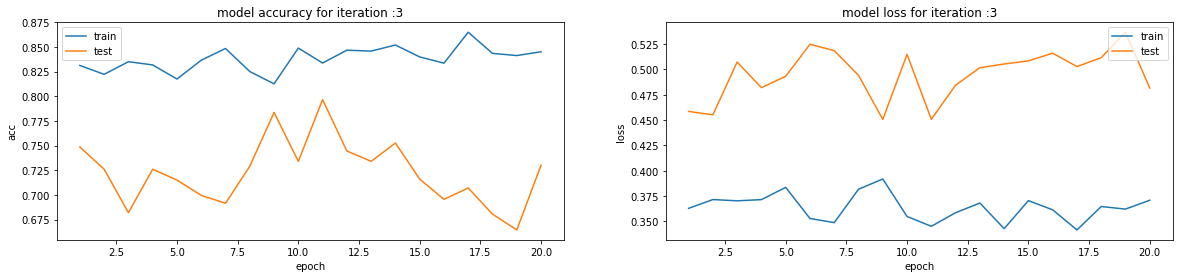

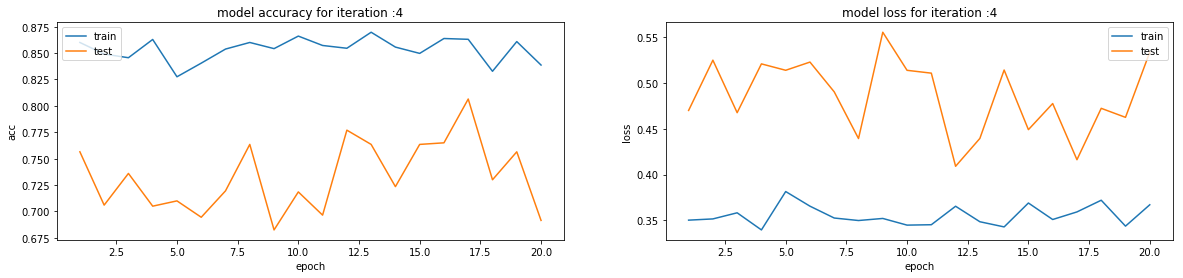

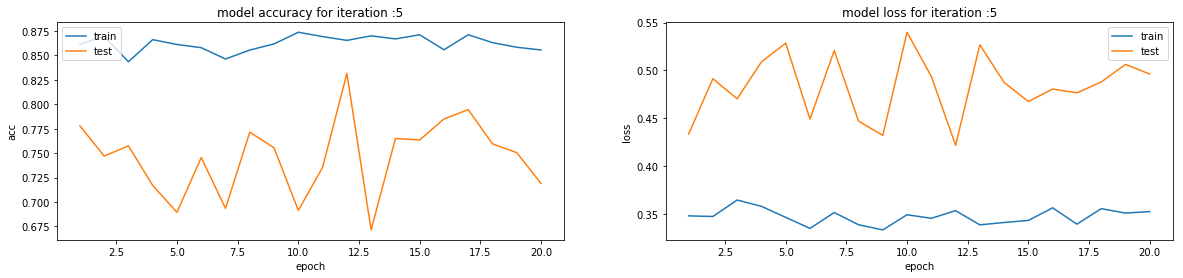

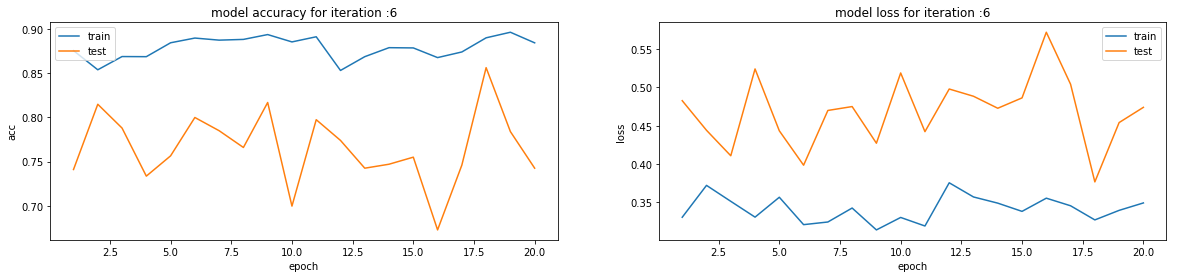

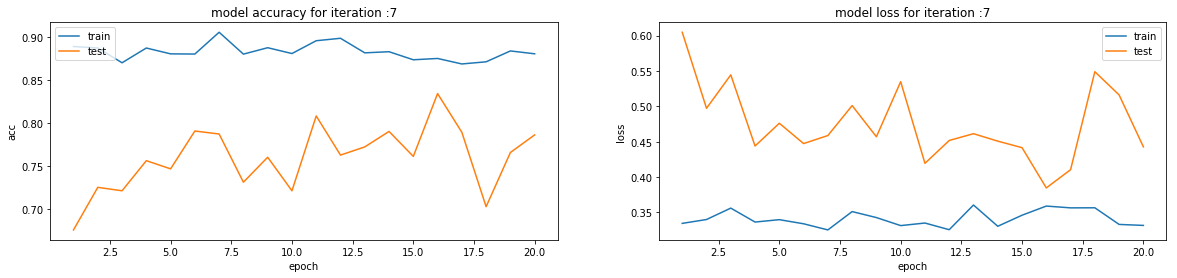

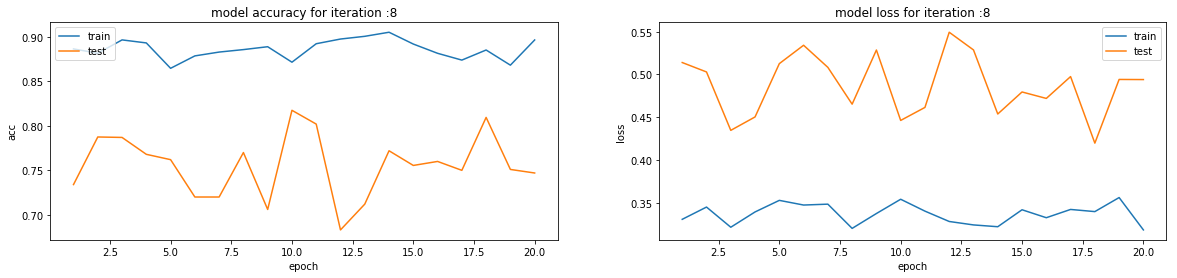

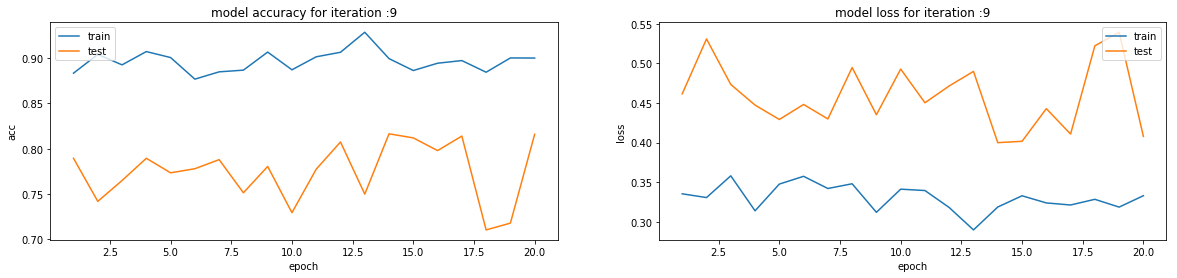

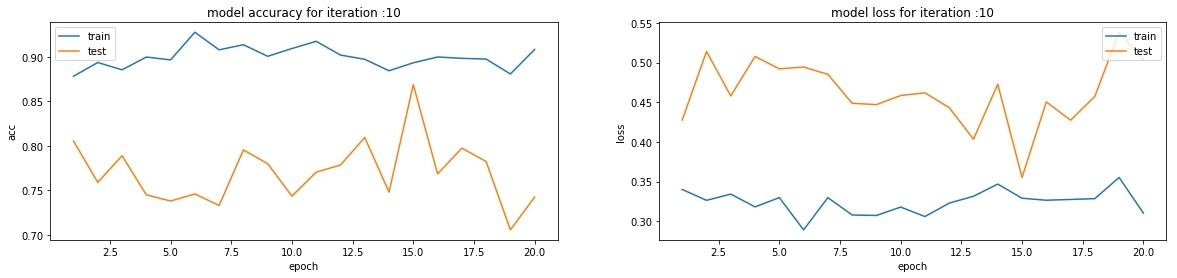

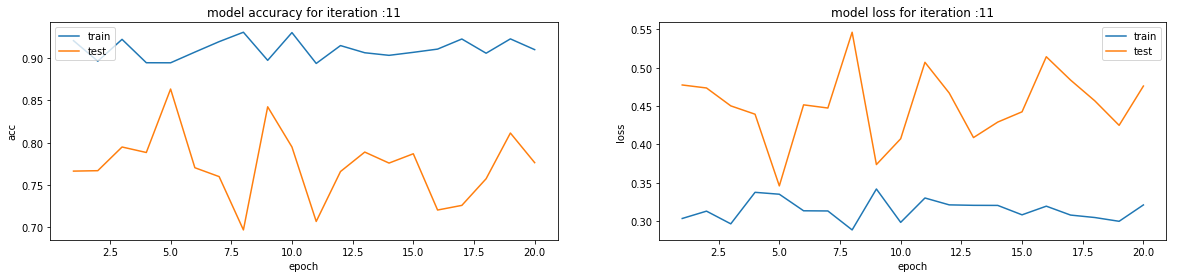

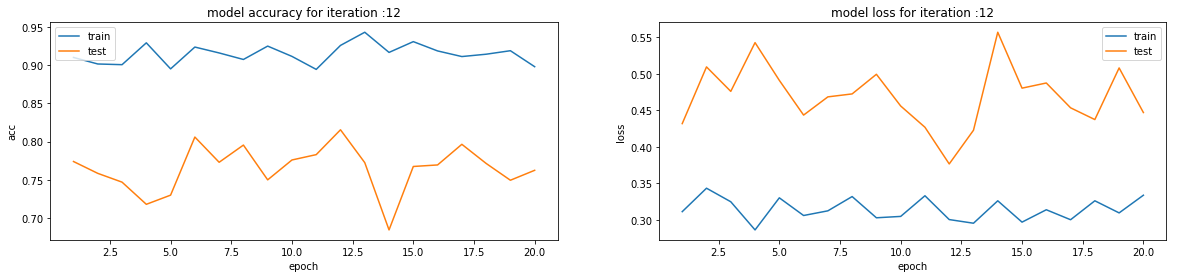

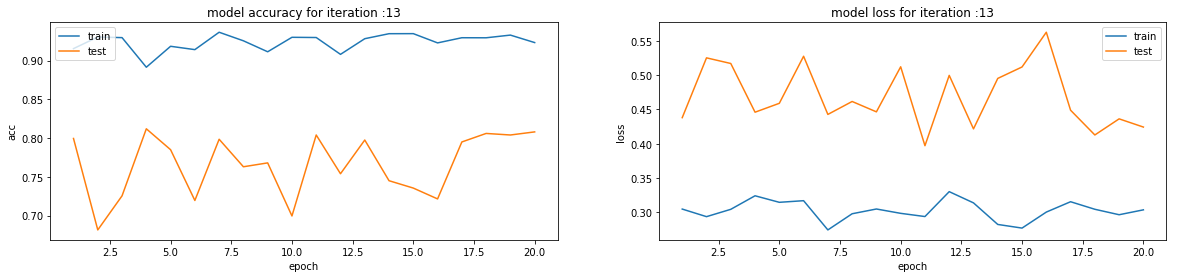

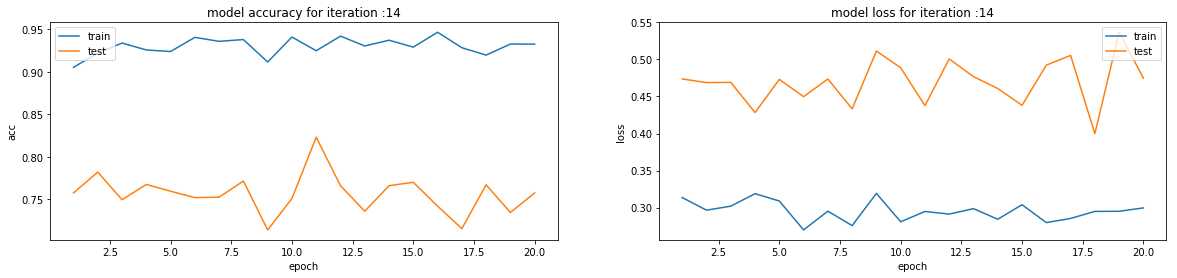

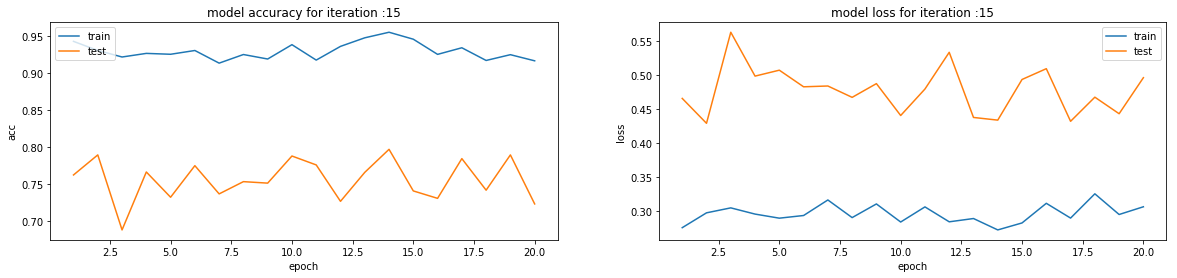

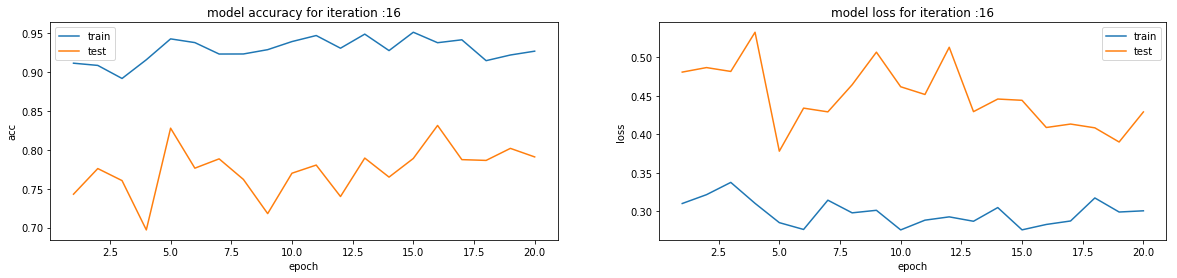

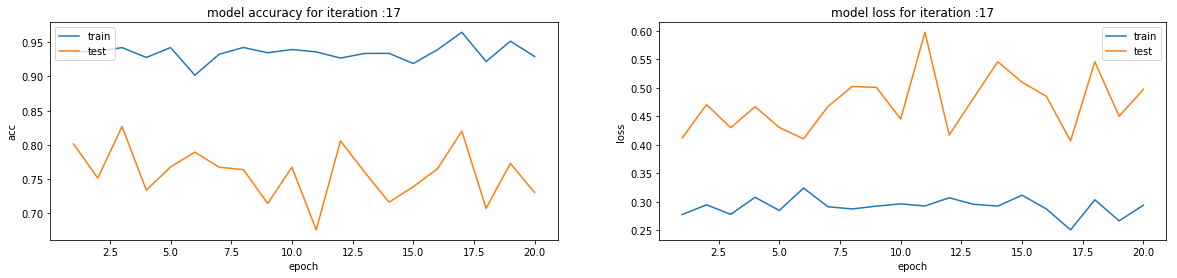

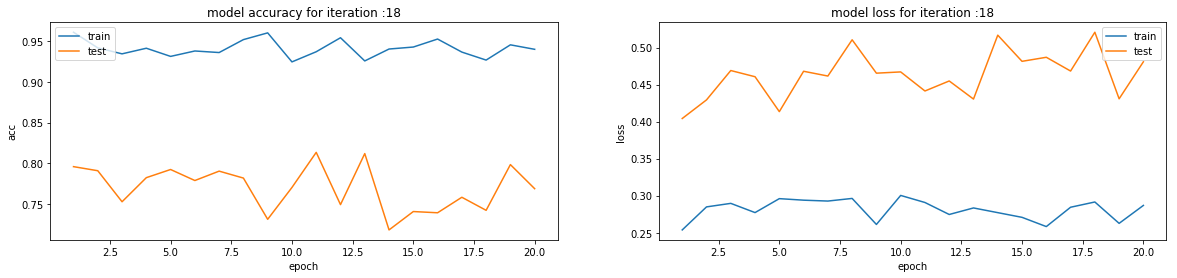

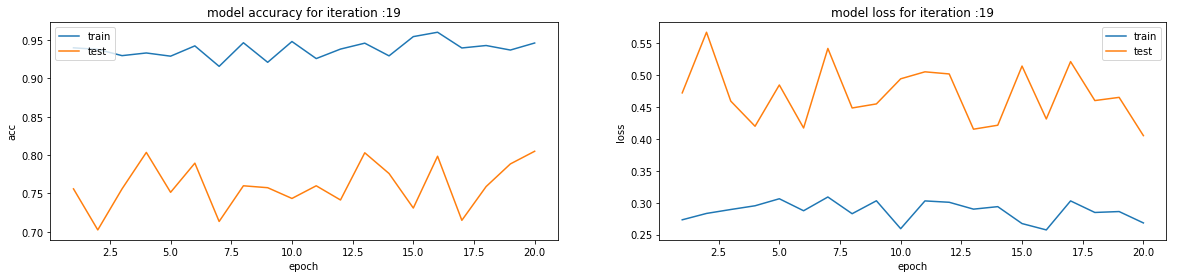

In [0]:
print(history_list[0].history)
for i in  range(len(history_list)):
     history = history_list[i]
     display_training_loss_and_accuracy(i, history)

In [0]:
model.load_weights(os.path.join(model_path, "seg_uniform_euclidean_weights.best.hdf5"))

In [0]:
import sklearn
from sklearn.metrics import roc_curve
(X_test, y_test) = generate_rnd_pairs(numofcategories=2, s="val")
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

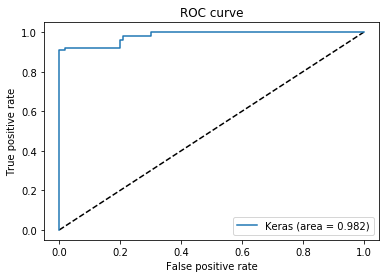

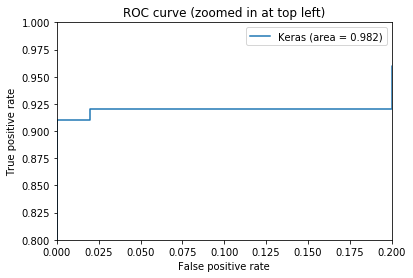

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()